Files already downloaded and verified
Tiempo de entrenamiento en JAX: 14.88 segundos.
Files already downloaded and verified
Tiempo de entrenamiento en PyTorch: 112.31 segundos.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2671 - loss: 12.7476
Tiempo de entrenamiento en TensorFlow: 9.26 segundos.


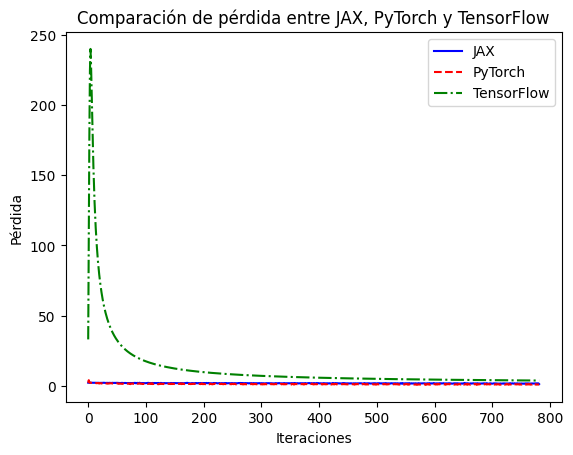

Comparación de JAX, TensorFlow y PyTorch en CIFAR-10 completada.


In [11]:
import jax
import jax.numpy as jnp
import tensorflow as tf
import torch
import torchvision
import torchvision.transforms as transforms
import flax.linen as nn
import optax
import matplotlib.pyplot as plt
from jax import random, grad, jit
from torch import nn as torch_nn, optim
from tensorflow import keras
from tensorflow.keras import layers
import time

# Cargar el dataset CIFAR-10
def load_cifar10():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    return trainloader

# Definir un modelo simple en JAX
class JaxCNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = x.mean(axis=(1, 2))
        x = nn.Dense(features=10)(x)
        return x

# Definir un modelo simple en PyTorch
class TorchCNN(torch_nn.Module):
    def __init__(self):
        super(TorchCNN, self).__init__()
        self.conv1 = torch_nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch_nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc = torch_nn.Linear(64 * 32 * 32, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Definir un modelo simple en TensorFlow
def create_tf_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(10)
    ])
    return model

# Entrenar en JAX
def train_jax():
    start_time = time.time()  # Iniciar el temporizador
    key = random.PRNGKey(0)
    model = JaxCNN()
    params = model.init(key, jnp.ones([1, 32, 32, 3]))
    optimizer = optax.adam(1e-3)
    opt_state = optimizer.init(params)
    trainloader = load_cifar10()
    losses = []

    @jit
    def loss_fn(params, x, y):
        logits = model.apply(params, x)
        return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits, y))

    @jit
    def update(params, opt_state, x, y):
        loss, grads = jax.value_and_grad(loss_fn)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    for epoch in range(1):  # Solo una época para prueba
        for images, labels in trainloader:
            images = jnp.array(images.permute(0, 2, 3, 1).numpy())  # Reordenar dimensiones
            labels = jnp.array(labels.numpy())
            params, opt_state, loss = update(params, opt_state, images, labels)
            losses.append(loss)

    end_time = time.time()  # Finalizar el temporizador
    print(f"Tiempo de entrenamiento en JAX: {end_time - start_time:.2f} segundos.")
    return losses


# Entrenar en PyTorch
def train_pytorch():
    start_time = time.time()  # Iniciar el temporizador
    model = TorchCNN()
    criterion = torch_nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    trainloader = load_cifar10()
    losses = []

    for epoch in range(1):  # Solo una época para prueba
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    end_time = time.time()  # Finalizar el temporizador
    print(f"Tiempo de entrenamiento en PyTorch: {end_time - start_time:.2f} segundos.")
    return losses


# Entrenar en TensorFlow
def train_tensorflow():
    start_time = time.time()  # Iniciar el temporizador
    model = create_tf_model()
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    (x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()

    # Crear un array para almacenar las pérdidas
    losses = []

    # Función de callback para registrar la pérdida
    class LossHistory(tf.keras.callbacks.Callback):
        def on_batch_end(self, batch, logs=None):
            losses.append(logs['loss'])

    # Entrenar el modelo con el callback
    model.fit(x_train, y_train, epochs=1, batch_size=64, verbose=1, callbacks=[LossHistory()])

    end_time = time.time()  # Finalizar el temporizador
    print(f"Tiempo de entrenamiento en TensorFlow: {end_time - start_time:.2f} segundos.")
    return losses

# Comparar pérdidas en gráficos con JAX, PyTorch y TensorFlow
def plot_losses(jax_losses, pytorch_losses, tensorflow_losses):
    plt.plot(jax_losses, label='JAX', linestyle='-', color='blue')
    plt.plot(pytorch_losses, label='PyTorch', linestyle='--', color='red')
    plt.plot(tensorflow_losses, label='TensorFlow', linestyle='-.', color='green')
    plt.xlabel('Iteraciones')
    plt.ylabel('Pérdida')
    plt.title('Comparación de pérdida entre JAX, PyTorch y TensorFlow')
    plt.legend()
    plt.show()

# Sección de ejecución
if __name__ == "__main__":
    jax_losses = train_jax()  # Ejecutar entrenamiento en JAX
    pytorch_losses = train_pytorch()  # Ejecutar entrenamiento en PyTorch
    tensorflow_losses = train_tensorflow()  # Ejecutar entrenamiento en TensorFlow
    plot_losses(jax_losses, pytorch_losses, tensorflow_losses)  # Mostrar comparación gráfica
    print("Comparación de JAX, TensorFlow y PyTorch en CIFAR-10 completada.")